# Data processing

**In this file we take a look at the dataset, focusing on formatting the data for the rest of the work**

**The dataset is located here https://www.kaggle.com/datasets/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018/data?select=2013.csv**

In [1]:
'''
%pip install kagglehub

import kagglehub

#Download latest version
path = kagglehub.dataset_download("yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018")

print("Path to dataset files:", path)

%pip install pandas
%pip install numpy
'''

'\n%pip install kagglehub\n\nimport kagglehub\n\n#Download latest version\npath = kagglehub.dataset_download("yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018")\n\nprint("Path to dataset files:", path)\n\n%pip install pandas\n%pip install numpy\n'

In [2]:
import pandas as pd
import numpy as np

df=pd.read_csv('2013.csv')

Let's start working with the data from 2013. Let's see what the dimensions of the dataset are and let's check what the types of each column are.

In [3]:
print(f"Dimensions of the dataset are: {np.shape(df)}")
print(df.dtypes) # Let's check what the types of each column are and whether it is correct or not

Dimensions of the dataset are: (6369482, 28)
FL_DATE                 object
OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE       object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtype: object


## Formatting

Our dataset has 6369482 rows and 28 columns.

As we can see from above, most numeric features are in float64 format, we ought to standardize the format of all of the numeric features to int64 instead. 

There is an unnecessary column 'Unnamed: 27' representing nothing and consisting only of NaN values. We will remove the column.


In [4]:
def numeric_to_int64(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Convert numeric types to Int64
            df[column] = df[column].round().astype('Int64')
    return df

df = numeric_to_int64(df)

df = df.drop(columns=['Unnamed: 27'], errors='ignore') # Removing the useless column

In addition, there are many times in the military time format : HHMM, we will convert them to a new, 'HH:MM' format.

In [5]:
def convert_to_time_format(value):
    if pd.isna(value):
        return pd.NaT
    value = int(value)  # In case it's stored as float
    hours = value // 100
    minutes = value % 100
    return f"{hours:02}:{minutes:02}"

time_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'CRS_ARR_TIME', 'ARR_TIME']
# Selecting the columns that should be transformed

for col in time_columns:
    df[col] = df[col].apply(convert_to_time_format) # Applying changes

There are also 2 attributes, which are functionally flags, however are still represented as int64, this is unpreferable in ML applications, we will fix this :

In [6]:
# Convert CANCELLED and DIVERTED to boolean
boolean_columns = ['CANCELLED', 'DIVERTED']
for col in boolean_columns:
    df[col] = df[col].astype(bool)

**Now we check the results of our formatting changes :**

In [7]:
print(df.dtypes)

FL_DATE                object
OP_CARRIER             object
OP_CARRIER_FL_NUM       Int64
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           object
DEP_TIME               object
DEP_DELAY               Int64
TAXI_OUT                Int64
WHEELS_OFF             object
WHEELS_ON              object
TAXI_IN                 Int64
CRS_ARR_TIME           object
ARR_TIME               object
ARR_DELAY               Int64
CANCELLED                bool
CANCELLATION_CODE      object
DIVERTED                 bool
CRS_ELAPSED_TIME        Int64
ACTUAL_ELAPSED_TIME     Int64
AIR_TIME                Int64
DISTANCE                Int64
CARRIER_DELAY           Int64
WEATHER_DELAY           Int64
NAS_DELAY               Int64
SECURITY_DELAY          Int64
LATE_AIRCRAFT_DELAY     Int64
dtype: object


Usually, it's considered bad etiquette to maintain composite attributes in databases. For this reason, let's split the 'FL_DATE' attribute into its smaller components:

In [8]:
# Convert FL_DATE to datetime if not already
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Extract month and day
df['MONTH'] = df['FL_DATE'].dt.month
df['DAY'] = df['FL_DATE'].dt.day
#df['YEAR'] = df['FL_DATE'].dt.year
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Optional: Drop original FL_DATE column
#df.drop(columns=['FL_DATE'], inplace=True)

# Verify the new columns
print("New columns added:")
print(df[['MONTH', 'DAY', 'DAY_OF_WEEK']].head())

# Quick statistical overview
print("\nMonth distribution:")
print(df['MONTH'].value_counts(normalize=True).sort_index() * 100)

print("\nDay of week distribution:")
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_dist = df['DAY_OF_WEEK'].value_counts(normalize=True).sort_index() * 100
day_dist.index = day_names
print(day_dist)

New columns added:
   MONTH  DAY  DAY_OF_WEEK
0      1    1            1
1      1    1            1
2      1    1            1
3      1    1            1
4      1    1            1

Month distribution:
MONTH
1     7.999379
2     7.374948
3     8.671223
4     8.421297
5     8.613605
6     8.668539
7     8.974403
8     8.837783
9     8.019585
10    8.404828
11    7.901679
12    8.112732
Name: proportion, dtype: float64

Day of week distribution:
Monday       14.901353
Tuesday      14.600230
Wednesday    14.620341
Thursday     14.833530
Friday       14.946788
Saturday     12.050038
Sunday       14.047720
Name: proportion, dtype: float64


## Checking for discrepencies

Let's start checking for discrepencies, we will start by checking the number of missing (null) values in columns.

In [9]:
df.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                 91681
DEP_DELAY                91681
TAXI_OUT                 94903
WHEELS_OFF               94903
WHEELS_ON                98275
TAXI_IN                  98275
CRS_ARR_TIME                 0
ARR_TIME                 98275
ARR_DELAY               110172
CANCELLED                    0
CANCELLATION_CODE      6273470
DIVERTED                     0
CRS_ELAPSED_TIME             5
ACTUAL_ELAPSED_TIME     110172
AIR_TIME                110172
DISTANCE                     0
CARRIER_DELAY          5100205
WEATHER_DELAY          5100205
NAS_DELAY              5100205
SECURITY_DELAY         5100205
LATE_AIRCRAFT_DELAY    5100205
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
dtype: int64

It's alarming that amount of missing values in 'WHEELS_OFF' and 'WHEELS_ON' isn't the same. Let's investigate.

In [10]:
# First filter for WHEELS_OFF not missing and WHEELS_ON missing
filtered_df = df[
    (df['WHEELS_OFF'].notna()) & 
    (df['WHEELS_ON'].isna())
]
print(f"Discrepency is present in : {np.shape(filtered_df)}")
# Additional filter for non-cancelled flights
filtered_df = filtered_df[
    (filtered_df['CANCELLED'] == False)
]
print(f"Discrepency after cancellations is present : {np.shape(filtered_df)}")

filtered_df = filtered_df[
    (filtered_df['DIVERTED'] == False)
]
print(f"Discrepency after diversions is present : {np.shape(filtered_df)}")

# Set display option to show all columns
pd.set_option('display.max_columns', None)

Discrepency is present in : (3372, 30)
Discrepency after cancellations is present : (2263, 30)
Discrepency after diversions is present : (0, 30)


In [11]:
df[['DEP_TIME', 'WHEELS_OFF']].isnull().sum()

DEP_TIME      91681
WHEELS_OFF    94903
dtype: int64

The number of missing values is not the same for 'DEP_TIME' and 'WHEELS_OFF'. Let's investigate:

In [12]:
# First filter
filtered_df = df[df['DEP_TIME'].notna() & df['WHEELS_OFF'].isna()]
print(np.shape(filtered_df))

# Corrected second filter
filtered_df2 = filtered_df[(filtered_df['CANCELLED'] == False)]
print(np.shape(filtered_df2))

pd.set_option('display.max_columns', None)

(3222, 30)
(0, 30)


It seems like there are cases where airplane has departed but has not touched off the ground. This would mean that airport has been driving on land for years which makes no sense.

However, we can see once again, that all of those flights were cancelled flights. Making the discrepency somewhat logical: the plane started to move but was unable to take off for whatever reason.

## Dealing with the Cancelled and Diverted flights

From those discrepencies, we can conclude that it is more practical to consider those special cases (cancelled and diverted flights), separately. After all, we cannot apply uniform analysis to normal flights and those exceptions.

In [13]:
df_cancel = df[
    (df['CANCELLED'] == True) | 
    (df['DIVERTED'] == True)
]

print(np.shape(df_cancel))

(110172, 30)


However, this means that some attributes become useless: the flags and 'CANCELLATION_CODE'. Just in case, let's first drop the cancelled and diverted flights from the main dataframe and then check if there are any non-NaN values in the CANCELLATON_CODE column left.

In [14]:
# First, drop cancelled and diverted flights
df_without_cancelled_diverted = df[
    (df['CANCELLED'] == False) & 
    (df['DIVERTED'] == False)
]

# Check for non-NaN values in CANCELLATION_CODE
non_nan_cancellation_codes = df_without_cancelled_diverted[
    df_without_cancelled_diverted['CANCELLATION_CODE'].notna()
]

# Print results
print("Total rows in original dataframe:", len(df))
print("Rows after removing cancelled/diverted flights:", len(df_without_cancelled_diverted))
print("Rows with non-NaN cancellation codes:", len(non_nan_cancellation_codes))

# If you want to see the unique non-NaN cancellation codes
print("\nUnique non-NaN Cancellation Codes:")
print(non_nan_cancellation_codes['CANCELLATION_CODE'].unique())

Total rows in original dataframe: 6369482
Rows after removing cancelled/diverted flights: 6259310
Rows with non-NaN cancellation codes: 0

Unique non-NaN Cancellation Codes:
[]


We can now safely drop all three of those columns : 

In [15]:
# Drop CANCELLED, DIVERTED, and CANCELLATION_CODE columns
df_cleaned = df_without_cancelled_diverted.drop(
    columns=['CANCELLED', 'DIVERTED', 'CANCELLATION_CODE']
)

# Verify the drop
print("Columns before dropping:", list(df_without_cancelled_diverted.columns))
print("Columns after dropping:", list(df_cleaned.columns))

# Optional: Verify the number of rows remains the same
print("Number of rows before dropping columns:", len(df_without_cancelled_diverted))
print("Number of rows after dropping columns:", len(df_cleaned))

Columns before dropping: ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK']
Columns after dropping: ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK']
Number of rows before dropping columns: 6259310
Number of rows after dropping columns: 6259310


### Let's check if any discrepancies remain

Now there are only few things left to check - whether amount of missing values in 'CANCELLATION_CODE' makes sense and whether the amounts of missing values in 'CARRIER_DELAY',
'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY' and 'LATE_AIRCRAFT_DELAY' make sense.

In [16]:
df_cleaned.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                     0
DEP_DELAY                    0
TAXI_OUT                     0
WHEELS_OFF                   0
WHEELS_ON                    0
TAXI_IN                      0
CRS_ARR_TIME                 0
ARR_TIME                     0
ARR_DELAY                    0
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME          0
AIR_TIME                     0
DISTANCE                     0
CARRIER_DELAY          4990033
WEATHER_DELAY          4990033
NAS_DELAY              4990033
SECURITY_DELAY         4990033
LATE_AIRCRAFT_DELAY    4990033
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
dtype: int64

Seemingly the normal flights list is now fixed.

### **Analysing the cancelled and diverted flights list**

Let's first see how many flights even were cancelled or diverted:

In [17]:
# Counting how many times a flight was not cancelled
cancelled_count = df_cancel[df_cancel['CANCELLED'] == 1].shape[0]
diverted_count = df_cancel[df_cancel['DIVERTED'] == 1].shape[0]

print(f'Number of Cancelled flights: {cancelled_count}')
print(f'Number of Diverted flights: {diverted_count}')

print(df_cancel.isnull().sum())

Number of Cancelled flights: 96012
Number of Diverted flights: 14160
FL_DATE                     0
OP_CARRIER                  0
OP_CARRIER_FL_NUM           0
ORIGIN                      0
DEST                        0
CRS_DEP_TIME                0
DEP_TIME                91681
DEP_DELAY               91681
TAXI_OUT                94903
WHEELS_OFF              94903
WHEELS_ON               98275
TAXI_IN                 98275
CRS_ARR_TIME                0
ARR_TIME                98275
ARR_DELAY              110172
CANCELLED                   0
CANCELLATION_CODE       14160
DIVERTED                    0
CRS_ELAPSED_TIME            5
ACTUAL_ELAPSED_TIME    110172
AIR_TIME               110172
DISTANCE                    0
CARRIER_DELAY          110172
WEATHER_DELAY          110172
NAS_DELAY              110172
SECURITY_DELAY         110172
LATE_AIRCRAFT_DELAY    110172
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
dtype: int64


There are 5 cases in which 'CRS_ELAPSED_TIME' has a missing value. However, it is possible to calculate it by using columns 'CRS_ARR_TIME' and 'CRS_DEP_TIME' which have no missing values.

In [18]:
missing_crs_elapsed_time = df_cancel[df_cancel['CRS_ELAPSED_TIME'].isna()]
print(missing_crs_elapsed_time[['ORIGIN','DEST','CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'CANCELLED', 'DIVERTED']])

#DENver = UTC(-7)
#BNA Nashville, MDW Chicago = UTC(-6) 
#SNA LA  UTC(-8)

        ORIGIN DEST CRS_DEP_TIME CRS_ARR_TIME  CRS_ELAPSED_TIME  CANCELLED  \
1060779    DEN  MDW        08:30        11:46              <NA>      False   
1060780    MDW  DEN        12:25        14:02              <NA>       True   
5389021    SNA  DEN        15:00        18:09              <NA>       True   
5768225    DEN  BNA        10:22        13:48              <NA>      False   
5768226    BNA  DEN        14:28        16:20              <NA>       True   

         DIVERTED  
1060779      True  
1060780     False  
5389021     False  
5768225      True  
5768226     False  


'CRS_ELAPSED_TIME' is computable, however, we also need to consider timezone differences, let's check the whole rows.

There are five flights which lack the planned elapsed time, to calculate this, we need to consider the departure and arrival airports and their timezones, for example : Chicago and Nashville are in the same timezone and Denver is 1 hour behind them. This means that the first flight's 'CRS_ELAPSED_TIME' should be 97 + 60 = 157. In a similar manner, we calculate 'CRS_ELAPSED_TIME' for the other four flights.

In [19]:
df_cancel.loc[df_cancel.index == 1060779, 'CRS_ELAPSED_TIME'] = 136  # DEN to  MDW
df_cancel.loc[df_cancel.index == 1060780, 'CRS_ELAPSED_TIME'] = 157  # MDW to DEN
df_cancel.loc[df_cancel.index == 5768226, 'CRS_ELAPSED_TIME'] = 172  # BNA to DEN
df_cancel.loc[df_cancel.index == 5389021, 'CRS_ELAPSED_TIME'] = 129  # SNA to DEN
df_cancel.loc[df_cancel.index == 5768225, 'CRS_ELAPSED_TIME'] = 146  # DEN to BNA

print(df_cancel.loc[[1060779,1060780, 5768226,5389021,5768225], ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME']]) # Checking if the missing values have been filled

        CRS_DEP_TIME CRS_ARR_TIME  CRS_ELAPSED_TIME
1060779        08:30        11:46               136
1060780        12:25        14:02               157
5768226        14:28        16:20               172
5389021        15:00        18:09               129
5768225        10:22        13:48               146


There are still a couple of problems within our data. At first, the amount of missing values in 'ARR_DELAY' is not equal to the amount of missing values in 'ARR_TIME'. Let's investigate.

In [20]:
filtered_df = df_cancel[df_cancel['ARR_TIME'].notna() & df_cancel['ARR_DELAY'].isna()] # Filtering rows where ARR_TIME is not missing, and ARR_DELAY is missing

pd.set_option('display.max_columns', None)

print(np.shape(df_cancel))
print(np.shape(filtered_df))

(110172, 30)
(11897, 30)


In [21]:
filtered_df2 = df_cleaned[df_cleaned['ARR_TIME'].notna() & df_cleaned['ARR_DELAY'].isna()]
print(np.shape(filtered_df2))

(0, 27)


^ There are no normal flights with this discrepency.

By the fact that these discrepencies are only consistent within the scope of cancelled/diverted flights, we can actually rationalize the missing 'ARR_TIME', 'ACTUAL_ELAPSED_TIME', 'ARR_DELAY' etc. values, the flight didn't arrive, thus the spent time, delay and others are undefined. 

## Feature engineering

### Rush Hour

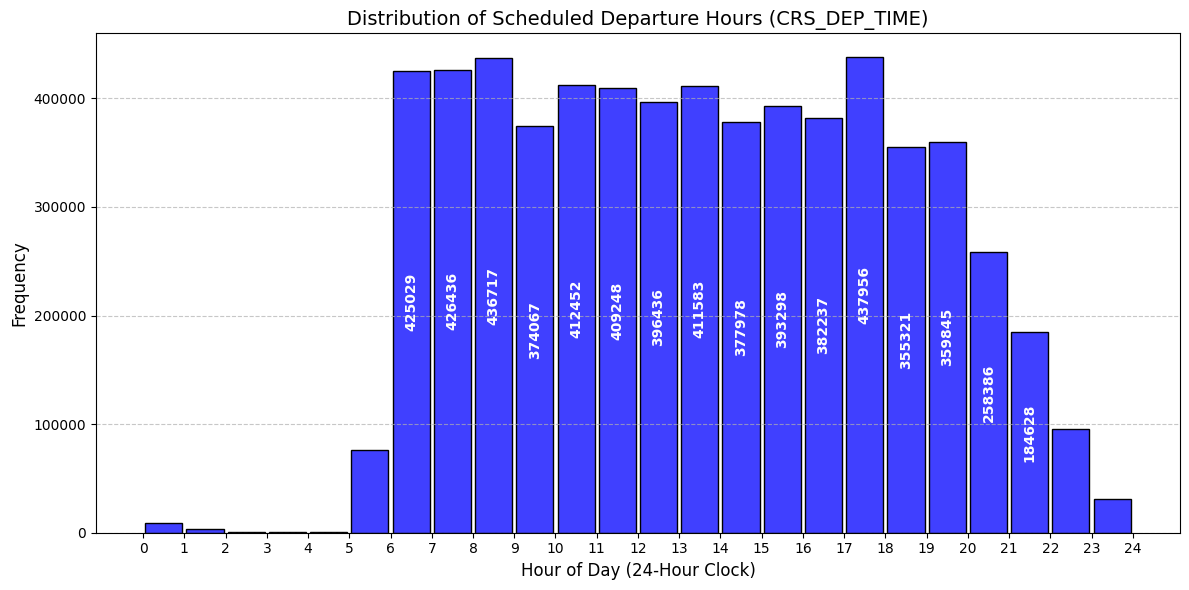

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns

# Ensuring 'CRS_DEP_TIME' is in the correct string format and extracting the hour
df_cleaned['DEP_Hour'] = df_cleaned['CRS_DEP_TIME'].str.split(':').str[0].astype(int)

# Plotting the distribution of DEP_Hour
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    df_cleaned['DEP_Hour'], 
    bins=range(25), 
    kde=False, 
    color='blue', 
    shrink=0.9  # Adjusts the bar width
)

# Adding text annotations inside each bar, vertically, only for counts > 100000
for p in ax.patches:
    count = int(p.get_height())  # Getting the height of each bar
    if count > 100000:  # Only annotating bars with counts over 100000
        ax.annotate(
            f'{count}',
            (p.get_x() + p.get_width() / 2., count / 2),  # Centering inside the bar
            ha='center', va='center', fontsize=10, color='white', weight='bold',
            rotation=90  # Makes the text vertical
        )


plt.title('Distribution of Scheduled Departure Hours (CRS_DEP_TIME)', fontsize=14)
plt.xlabel('Hour of Day (24-Hour Clock)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From this plot, it is possible to see that the distribution of planned departure time is very similar from 6:00 to 19:59. Timespan 17:00 - 17:59 had the most planned departures (437956) and it was closely followed by timespan 8:00 - 8:59 (436717 planned departures). Third most popular timespan for planned departures was 7:00 - 7:59 with 426436 planned departures. Let's classify only timespans 17:00 - 17:59 and 8:00 - 8:59 as rush hours for departures and it could be useful later.

Let's create a binary feature 'DEP_Rush_Hour' that has value 1 when scheduled departure time was in timespans 8:00 - 8:59 or 17:00 - 17:59. We can use previously defined feature 'DEP_Hour' to define this feature.

In [23]:
Rush_Hour = [8, 17]

# Create the binary feature for rush hour
df_cleaned['DEP_Rush_Hour'] = df_cleaned['DEP_Hour'].apply(lambda x: 1 if x in Rush_Hour else 0)

# Check if the feature worked
print(df_cleaned[['DEP_Hour', 'DEP_Rush_Hour']].head(20))

    DEP_Hour  DEP_Rush_Hour
0          7              0
1         22              0
2          7              0
3          7              0
4         11              0
5         11              0
6         15              0
7         20              0
8          7              0
9         21              0
10         7              0
11        16              0
12         8              1
13         8              1
14        17              1
15        23              0
16        19              0
17        21              0
18        20              0
19         9              0


Now, let's repeat the process for arrivals but now focus on actual arrival times, not scheduled arrival times. Reasoning for focusing on actual arrival times is that results from further analysis will be more realistic.

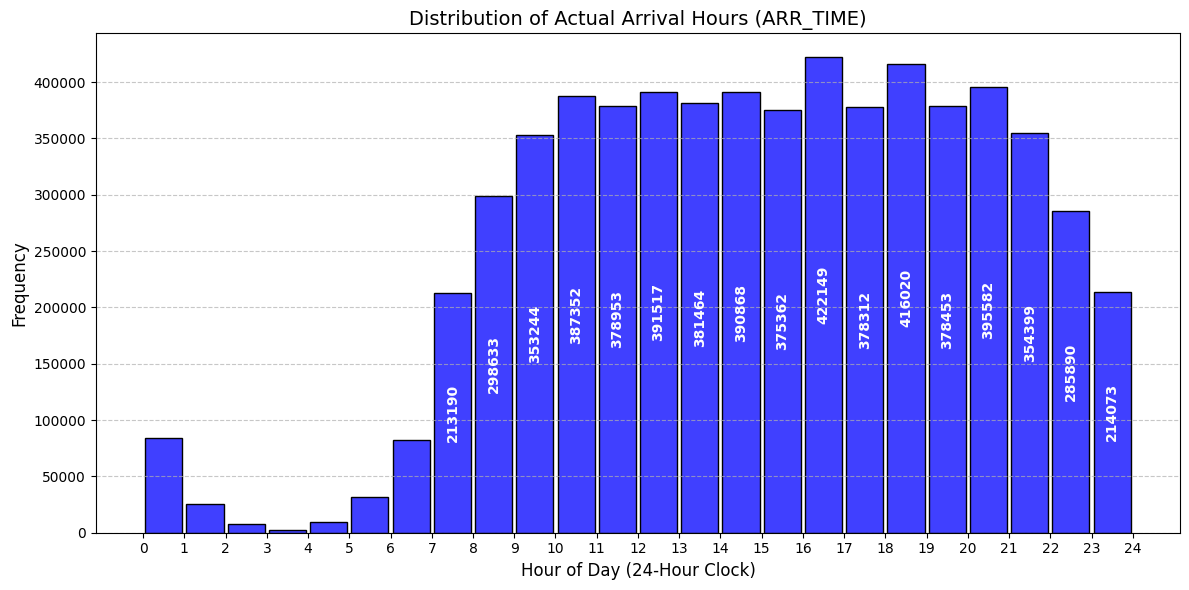

In [24]:

# Creating the 'ARR_Hour' feature, extract hour only for non-NaT values
df_cleaned['ARR_Hour'] = df_cleaned['ARR_TIME'].apply(lambda x: int(x.split(':')[0]) if pd.notna(x) else pd.NaT)



# Plotting the distribution of DEP_Hour
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    df_cleaned['ARR_Hour'], 
    bins=range(25), 
    kde=False, 
    color='blue', 
    shrink=0.9  # Adjusts the bar width
)

# Adding text annotations inside each bar, vertically, only for counts > 100000
for p in ax.patches:
    count = int(p.get_height())  # Getting the height of each bar
    if count > 100000:  # Only annotating bars with counts over 100000
        ax.annotate(
            f'{count}',
            (p.get_x() + p.get_width() / 2., count / 2),  # Centering inside the bar
            ha='center', va='center', fontsize=10, color='white', weight='bold',
            rotation=90  # Makes the text vertical
        )


plt.title('Distribution of Actual Arrival Hours (ARR_TIME)', fontsize=14)
plt.xlabel('Hour of Day (24-Hour Clock)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From this plot, it is possible to see that the distribution of actual arrival time is very similar from 9:00 to 21:59. Timespan 16:00 - 16:59 had the most actual arrivals (422149) and it was closely followed by timespan 18:00 - 18:59 (416020 actual arrivals). Third most popular timespan for actual arrivals was 20:00 - 20:59 with 395582 planned departures. Let's classify only timespans 16:00 - 16:59 and 18:00 - 18:59 as rush hours for actual arrivals, this could be later useful.

Let's create a binary feature 'ARR_Rush_Hour' that has value 1 when actual arrival time was in timespans 16:00 - 16:59 or 18:00 - 18:59. We can use previously defined feature 'ARR_Hour' to define this feature.

In [25]:
Rush_Hour = [16, 18]

# Create the binary feature for rush hour
df_cleaned['ARR_Rush_Hour'] = df_cleaned['ARR_Hour'].apply(lambda x: 1 if x in Rush_Hour else 0)

# Check if the feature worked
print(df_cleaned[['ARR_Hour', 'ARR_Rush_Hour']].head(20))

    ARR_Hour  ARR_Rush_Hour
0         14              0
1          5              0
2         10              0
3         10              0
4         18              1
5         14              0
6         23              0
7         23              0
8         15              0
9          5              0
10        14              0
11        19              0
12        16              1
13        11              0
14        21              0
15         7              0
16        20              0
17        23              0
18        21              0
19        10              0


#### Testing rush_hour metric

Here we compare the arrival delay of flights that arrived during rush hour to the delay of flights that did not arrive during rush hour.

Rush Hour Delay Comparison:
   ARR_Rush_Hour  Mean Delay  Median Delay  Std Delay    Count
0              0    5.992612          -4.0  38.492842  5421141
1              1    6.128973          -2.0  35.066926   838169


C:\Users\Kaarel\AppData\Local\Temp\ipykernel_23616\3283561114.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


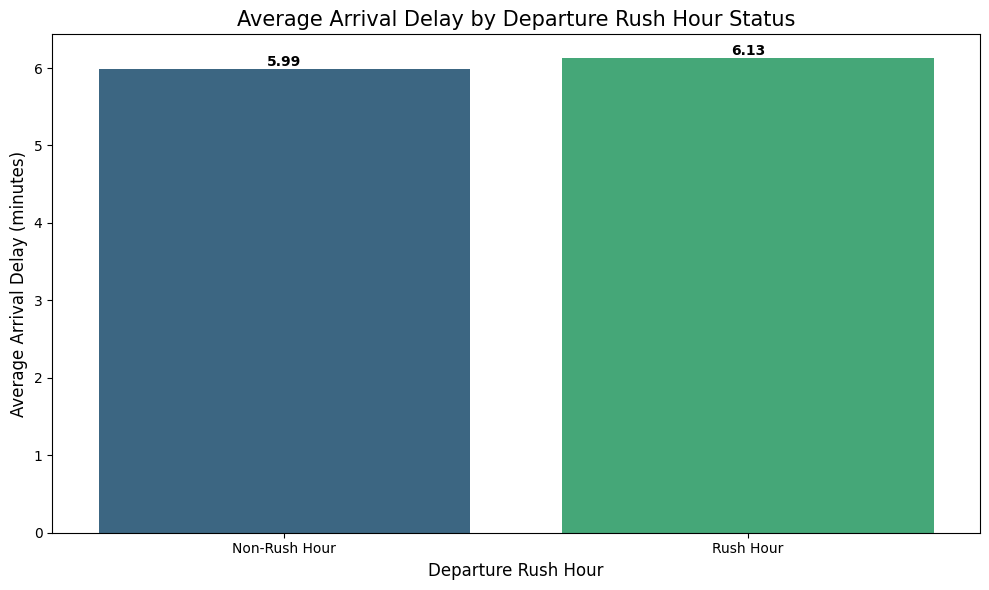

In [26]:
# Group by ARR_Rush_Hour and calculate mean ARR_DELAY
rush_hour_delay_comparison = df_cleaned.groupby('ARR_Rush_Hour')['ARR_DELAY'].agg([
    ('Mean Delay', 'mean'),
    ('Median Delay', 'median'),
    ('Std Delay', 'std'),
    ('Count', 'count')
]).reset_index()

# Print the comparison statistics
print("Rush Hour Delay Comparison:")
print(rush_hour_delay_comparison)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='ARR_Rush_Hour', 
    y='Mean Delay', 
    data=rush_hour_delay_comparison,
    palette='viridis'
)

plt.title('Average Arrival Delay by Departure Rush Hour Status', fontsize=15)
plt.xlabel('Departure Rush Hour', fontsize=12)
plt.ylabel('Average Arrival Delay (minutes)', fontsize=12)
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])

# Add value labels on top of each bar
for i, v in enumerate(rush_hour_delay_comparison['Mean Delay']):
    plt.text(
        i, 
        v, 
        f'{v:.2f}', 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# Optional: Statistical significance test
from scipy import stats

# Separate delay groups
rush_hour_delays = df_cleaned[df_cleaned['ARR_Rush_Hour'] == True]['ARR_DELAY']
non_rush_hour_delays = df_cleaned[df_cleaned['ARR_Rush_Hour'] == False]['ARR_DELAY']


Here we compare the departure delay of flights that departed during rush hour to the delay of flights that did not depart during rush hour.

Rush Hour Delay Comparison:
   DEP_Rush_Hour  Mean Delay  Median Delay  Std Delay    Count
0              0    9.729281          -1.0   35.51531  5384637
1              1    9.411104          -1.0  35.882659   874673


C:\Users\Kaarel\AppData\Local\Temp\ipykernel_23616\1457195102.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


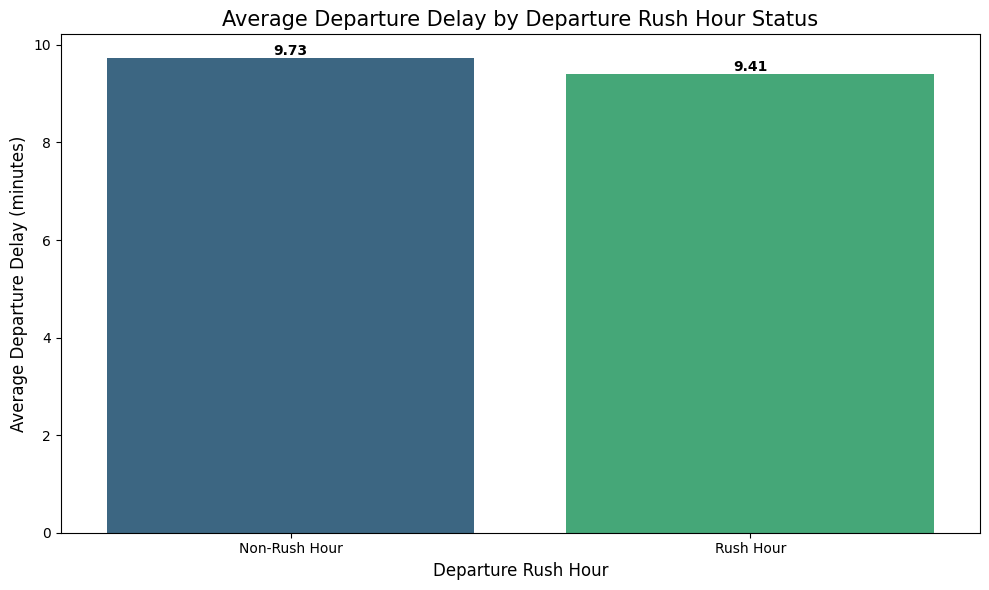

In [27]:
# Group by DEP_Rush_Hour and calculate mean DEP_DELAY
rush_hour_delay_comparison = df_cleaned.groupby('DEP_Rush_Hour')['DEP_DELAY'].agg([
    ('Mean Delay', 'mean'),
    ('Median Delay', 'median'),
    ('Std Delay', 'std'),
    ('Count', 'count')
]).reset_index()

# Print the comparison statistics
print("Rush Hour Delay Comparison:")
print(rush_hour_delay_comparison)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='DEP_Rush_Hour', 
    y='Mean Delay', 
    data=rush_hour_delay_comparison,
    palette='viridis'
)

plt.title('Average Departure Delay by Departure Rush Hour Status', fontsize=15)
plt.xlabel('Departure Rush Hour', fontsize=12)
plt.ylabel('Average Departure Delay (minutes)', fontsize=12)
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])

# Add value labels on top of each bar
for i, v in enumerate(rush_hour_delay_comparison['Mean Delay']):
    plt.text(
        i, 
        v, 
        f'{v:.2f}', 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


### Number of concurrent flights: congestion level

We will try to develop another feature to estimate the congestion of airports at certain times, let's take a look at our current date and time format.

In [28]:
print(df_cleaned[['MONTH', 'DAY', 'CRS_DEP_TIME']].dtypes)
print("\nRandom Row Values:")
print(df_cleaned.iloc[33][['MONTH', 'DAY', 'CRS_DEP_TIME']])

MONTH            int32
DAY              int32
CRS_DEP_TIME    object
dtype: object

Random Row Values:
MONTH               1
DAY                 1
CRS_DEP_TIME    10:30
Name: 33, dtype: object


Let's reformat this into a more convinient form.

In [29]:
df_congestion = df_cleaned.copy()

df_congestion['flight_datetime'] = pd.to_datetime({
    'year': 2013,
    'month': df_congestion['MONTH'],
    'day': df_congestion['DAY'],
    'hour': df_congestion['CRS_DEP_TIME'].str.split(':').str[0].astype(int),  # Get hours
    'minute': df_congestion['CRS_DEP_TIME'].str.split(':').str[1].astype(int)  # Get minutes
})

**What is the congestion level?**

We look at all the flights taking off from a specific airport. If these flights are designated to take off within a short timeframe, we can presume that the runway traffic or taking off in general might become difficult. 

The primary question here would be, what is the correct timeframe? We have currently opted for 2 hours, meaning if another flight was planned to take off within 2 hours we consider it might congest the flight and add 1 to the score. 

The timeframe could be far longer, 4, 5, 6, 7 hours etc.

Flight Datetime Range:
Earliest: 2013-01-01 02:02:00
Latest: 2013-12-31 23:59:00

Flight Datetime Distribution:
flight_datetime
0       885
1       383
2        83
3        84
4        65
5      7599
6     42504
7     42931
8     43609
9     37350
10    41129
11    41096
12    39723
13    41223
14    37693
15    39445
16    37918
17    43826
18    35388
19    36004
20    25743
21    18602
22     9482
23     3166
Name: count, dtype: int64
Congestion Level Summary:
count    625931.000000
mean          9.454056
std           8.134501
min           1.000000
25%           3.000000
50%           7.000000
75%          14.000000
max          53.000000
Name: CONGESTION_LEVEL, dtype: float64

Top 10 Airports by Maximum Congestion:
       CONGESTION_LEVEL           
                   mean max  count
ORIGIN                            
ATL           27.382342  53  39279
ORD           20.777838  42  29546
DFW           20.026848  38  27823
DEN           16.256255  38  22142
LAX           14.438680 

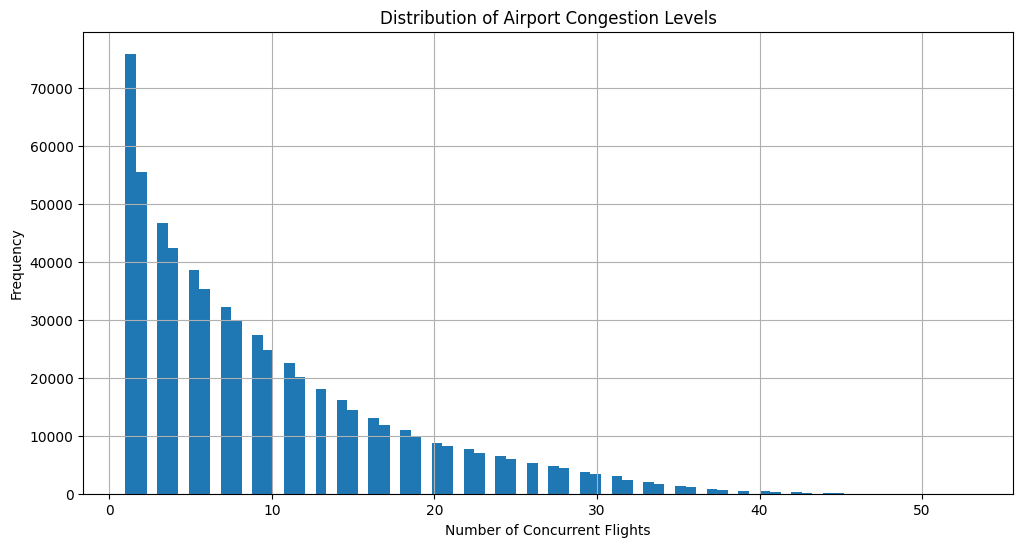

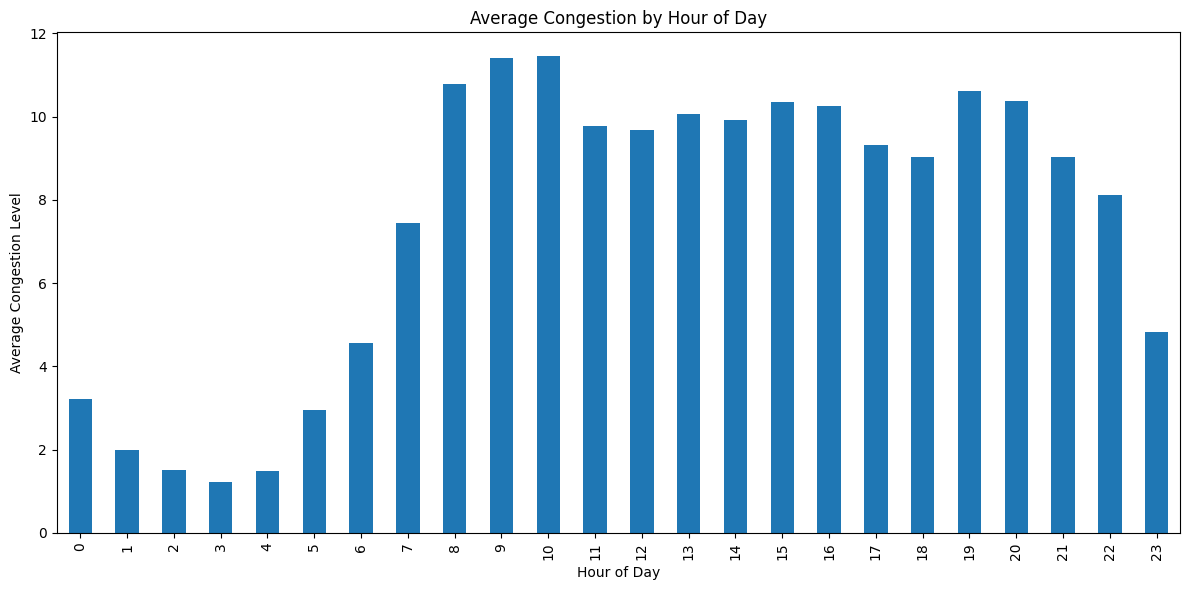

In [30]:
import pandas as pd
import numpy as np

def calculate_airport_congestion(combined_flights, time_window_minutes=120):
    # Create a copy of the dataframe
    df = combined_flights.copy()
    
    # Sort by airport and datetime
    df_sorted = df.sort_values(['ORIGIN', 'flight_datetime'])
    
    def count_concurrent_flights(group):
        # Use the existing flight_datetime
        full_datetimes = group['flight_datetime']
        
        # Initialize congestion array
        congestion = np.zeros(len(full_datetimes), dtype=int)
        
        for i, current_datetime in enumerate(full_datetimes):
            # Create time window mask
            mask = (np.abs(full_datetimes - current_datetime) <= pd.Timedelta(minutes=time_window_minutes))
            congestion[i] = np.sum(mask)
        
        return pd.Series(congestion, name='CONGESTION_LEVEL', index=group.index)
    
    # Group by origin and calculate congestion
    congestion_results = df_sorted.groupby('ORIGIN').apply(count_concurrent_flights)
    
    # Flatten the multi-index series
    congestion_results = congestion_results.reset_index(level=0, drop=True)
    
    # Add congestion level to the dataframe
    df['CONGESTION_LEVEL'] = 0  # Initialize with zeros
    df.loc[congestion_results.index, 'CONGESTION_LEVEL'] = congestion_results
    
    return df

# Comprehensive analysis function
def analyze_congestion(df, top_n=10):
    # Basic congestion summary
    print("Congestion Level Summary:")
    print(df['CONGESTION_LEVEL'].describe())
    
    # Top airports by congestion
    airport_congestion = df.groupby('ORIGIN').agg({
        'CONGESTION_LEVEL': ['mean', 'max', 'count']
    }).sort_values(('CONGESTION_LEVEL', 'max'), ascending=False)
    
    print(f"\nTop {top_n} Airports by Maximum Congestion:")
    print(airport_congestion.head(top_n))
    
    # Visualization
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12,6))
    df['CONGESTION_LEVEL'].hist(bins=80)
    plt.title('Distribution of Airport Congestion Levels')
    plt.xlabel('Number of Concurrent Flights')
    plt.ylabel('Frequency')
    plt.show()
    
    return airport_congestion

# Diagnostic function to check data quality
def diagnose_time_conversion(df):
    print("Flight Datetime Range:")
    print(f"Earliest: {df['flight_datetime'].min()}")
    print(f"Latest: {df['flight_datetime'].max()}")
    
    print("\nFlight Datetime Distribution:")
    print(df['flight_datetime'].dt.hour.value_counts().sort_index())

# Example usage with diagnostics
def main_analysis(combined_flights):
    # Sample a fraction of the data
    combined_flights_sample = combined_flights.sample(frac=0.1, random_state=42)
    
    # Diagnose time conversion
    diagnose_time_conversion(combined_flights_sample)
    
    # Calculate congestion
    result = calculate_airport_congestion(combined_flights_sample)
    
    # Analyze congestion
    congestion_analysis = analyze_congestion(result)
    
    return result, congestion_analysis

# Optional: Hourly congestion visualization
def plot_hourly_congestion(df):
    import matplotlib.pyplot as plt
    
    # Group by hour and calculate mean congestion
    hourly_congestion = df.groupby(df['flight_datetime'].dt.hour)['CONGESTION_LEVEL'].mean()
    
    plt.figure(figsize=(12,6))
    hourly_congestion.plot(kind='bar')
    plt.title('Average Congestion by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Congestion Level')
    plt.tight_layout()
    plt.show()

# Run the analysis
df_congestion1 = df_congestion#.sample(frac=0.1, random_state=42)
result, congestion_analysis = main_analysis(df_congestion1)

# Optional additional visualization
plot_hourly_congestion(result)

We can see that the distribution of concurrent flights is quite expected (seemingly exponential).

From the second graph, denoting the number of concurrent flights according to the hour of the day, we see similar results to those of the rush hour analysis: less flights during midnight and early morning hours, more flights from the morning to the evening. 

### Historical route delays

**Using the data of all flight routes to find which flights are most likely to be delayed**

Route Delay Metrics Summary:
Total Routes Analyzed: 4706
Routes with 10+ Flights: 4570

Delay Statistics:
       MEAN_ROUTE_DELAY  MEDIAN_ROUTE_DELAY  MAX_ROUTE_DELAY
count            4706.0              4706.0           4706.0
mean           5.898809           -3.174989       374.364853
std           10.009018            9.157573       244.439049
min               -35.0               -37.0            -35.0
25%            1.283925                -6.0            233.0
50%            5.377321                -4.0            322.5
75%            9.633999                -1.0            439.0
max               315.0               315.0           1983.0

Top 10 Routes by Delay Severity:
     ORIGIN DEST  MEAN_ROUTE_DELAY  MEDIAN_ROUTE_DELAY  MAX_ROUTE_DELAY  \
3789    PPG  HNL         53.773585                 1.0             1783   
729     CLE  CHS         -5.272727               -18.0              242   
2207    JAC  IAH              23.0                -5.0              337   
3071    MSO

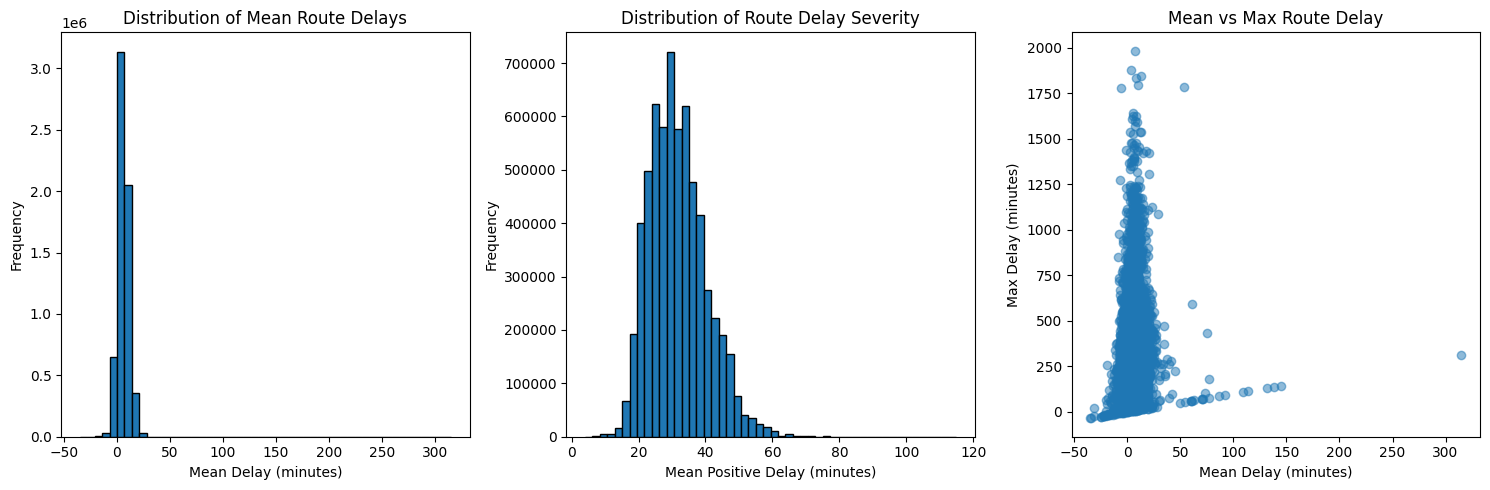

In [31]:
def add_historical_route_delay_severity(flights_df, min_flights=10):
    """
    Calculate route delay severity based on actual delay minutes
    
    Parameters:
    - flights_df: Input dataframe
    - min_flights: Minimum number of flights for a route to be considered
    """
    # Calculate route delay statistics
    route_delay_stats = flights_df.groupby(['ORIGIN', 'DEST']).agg({
        'ARR_DELAY': [
            ('mean_delay', 'mean'),           # Average delay for the route
            ('median_delay', 'median'),        # Median delay for the route
            ('max_delay', 'max'),              # Maximum delay for the route
            ('total_delay_minutes', 'sum'),    # Total delay minutes
            ('delay_severity', lambda x: np.mean(np.abs(x[x > 0]))),  # Mean of positive delays
            ('total_flights', 'count')         # Total number of flights
        ]
    }).reset_index()

    # Flatten multi-level column names
    route_delay_stats.columns = [
        'ORIGIN', 'DEST', 
        'MEAN_ROUTE_DELAY', 'MEDIAN_ROUTE_DELAY', 'MAX_ROUTE_DELAY', 
        'TOTAL_ROUTE_DELAY_MINUTES', 'MEAN_POSITIVE_DELAY', 'TOTAL_FLIGHTS'
    ]

    # Calculate delay severity metrics for routes with sufficient data
    route_delay_stats['ROUTE_DELAY_SEVERITY'] = np.where(
        route_delay_stats['TOTAL_FLIGHTS'] >= min_flights,
        route_delay_stats['MEAN_POSITIVE_DELAY'],
        np.nan
    )

    # Merge the route delay metrics back to the original dataframe
    flights_with_delay_metrics = flights_df.merge(
        route_delay_stats[[
            'ORIGIN', 'DEST', 
            'MEAN_ROUTE_DELAY', 
            'MEDIAN_ROUTE_DELAY', 
            'MAX_ROUTE_DELAY', 
            'ROUTE_DELAY_SEVERITY'
        ]],
        on=['ORIGIN', 'DEST'],
        how='left'
    )

    # Fill NaN with overall mean metrics
    overall_mean_delay = route_delay_stats['MEAN_ROUTE_DELAY'].mean()
    overall_delay_severity = route_delay_stats['ROUTE_DELAY_SEVERITY'].mean()
    
    flights_with_delay_metrics['MEAN_ROUTE_DELAY'].fillna(overall_mean_delay, inplace=True)
    flights_with_delay_metrics['ROUTE_DELAY_SEVERITY'].fillna(overall_delay_severity, inplace=True)

    # Print comprehensive statistics
    print("Route Delay Metrics Summary:")
    print(f"Total Routes Analyzed: {len(route_delay_stats)}")
    print(f"Routes with {min_flights}+ Flights: {len(route_delay_stats[route_delay_stats['TOTAL_FLIGHTS'] >= min_flights])}")
    
    print("\nDelay Statistics:")
    print(route_delay_stats[['MEAN_ROUTE_DELAY', 'MEDIAN_ROUTE_DELAY', 'MAX_ROUTE_DELAY', 'ROUTE_DELAY_SEVERITY']].describe())

    # Top 10 routes by delay severity
    print("\nTop 10 Routes by Delay Severity:")
    top_routes = route_delay_stats[route_delay_stats['TOTAL_FLIGHTS'] >= min_flights].sort_values(
        'ROUTE_DELAY_SEVERITY', 
        ascending=False
    ).head(10)
    print(top_routes)

    # Visualization
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Mean Route Delay Distribution
    plt.subplot(1, 3, 1)
    plt.hist(
        flights_with_delay_metrics['MEAN_ROUTE_DELAY'].dropna(),
        bins=50,
        edgecolor='black'
    )
    plt.title('Distribution of Mean Route Delays')
    plt.xlabel('Mean Delay (minutes)')
    plt.ylabel('Frequency')

    # Subplot 2: Route Delay Severity Distribution
    plt.subplot(1, 3, 2)
    plt.hist(
        flights_with_delay_metrics['ROUTE_DELAY_SEVERITY'].dropna(),
        bins=50,
        edgecolor='black'
    )
    plt.title('Distribution of Route Delay Severity')
    plt.xlabel('Mean Positive Delay (minutes)')
    plt.ylabel('Frequency')

    # Subplot 3: Scatter of Mean Delay vs Max Delay
    plt.subplot(1, 3, 3)
    plt.scatter(
        route_delay_stats['MEAN_ROUTE_DELAY'], 
        route_delay_stats['MAX_ROUTE_DELAY'],
        alpha=0.5
    )
    plt.title('Mean vs Max Route Delay')
    plt.xlabel('Mean Delay (minutes)')
    plt.ylabel('Max Delay (minutes)')

    plt.tight_layout()
    plt.show()

    return flights_with_delay_metrics

flights_with_delay_metrics = df_congestion.copy()
flights_with_delay_metrics = add_historical_route_delay_severity(
    flights_with_delay_metrics, 
    min_flights=10  # Routes with at least 10 flights
)

From the first graph we can clearly see that most flight routes are strongly centered around a mean of 0 minutes of delay.

From the second graph we can see, if there is a delay, how long on average it is for the routes. This is centered around about 30 minutes, meaning that if there is a delay on any route, the delay on average is around 30 minutes.

The final graph shows on the x-axis the mean delay of routes and on the y-axis the maximal delay of routes, this allows us to see the average delay of routes relative to the highest delay recorded on the route. Not many concrete conclusions to be made about this graph, other than the fact that there are many outliers.

#### Correlation with delay

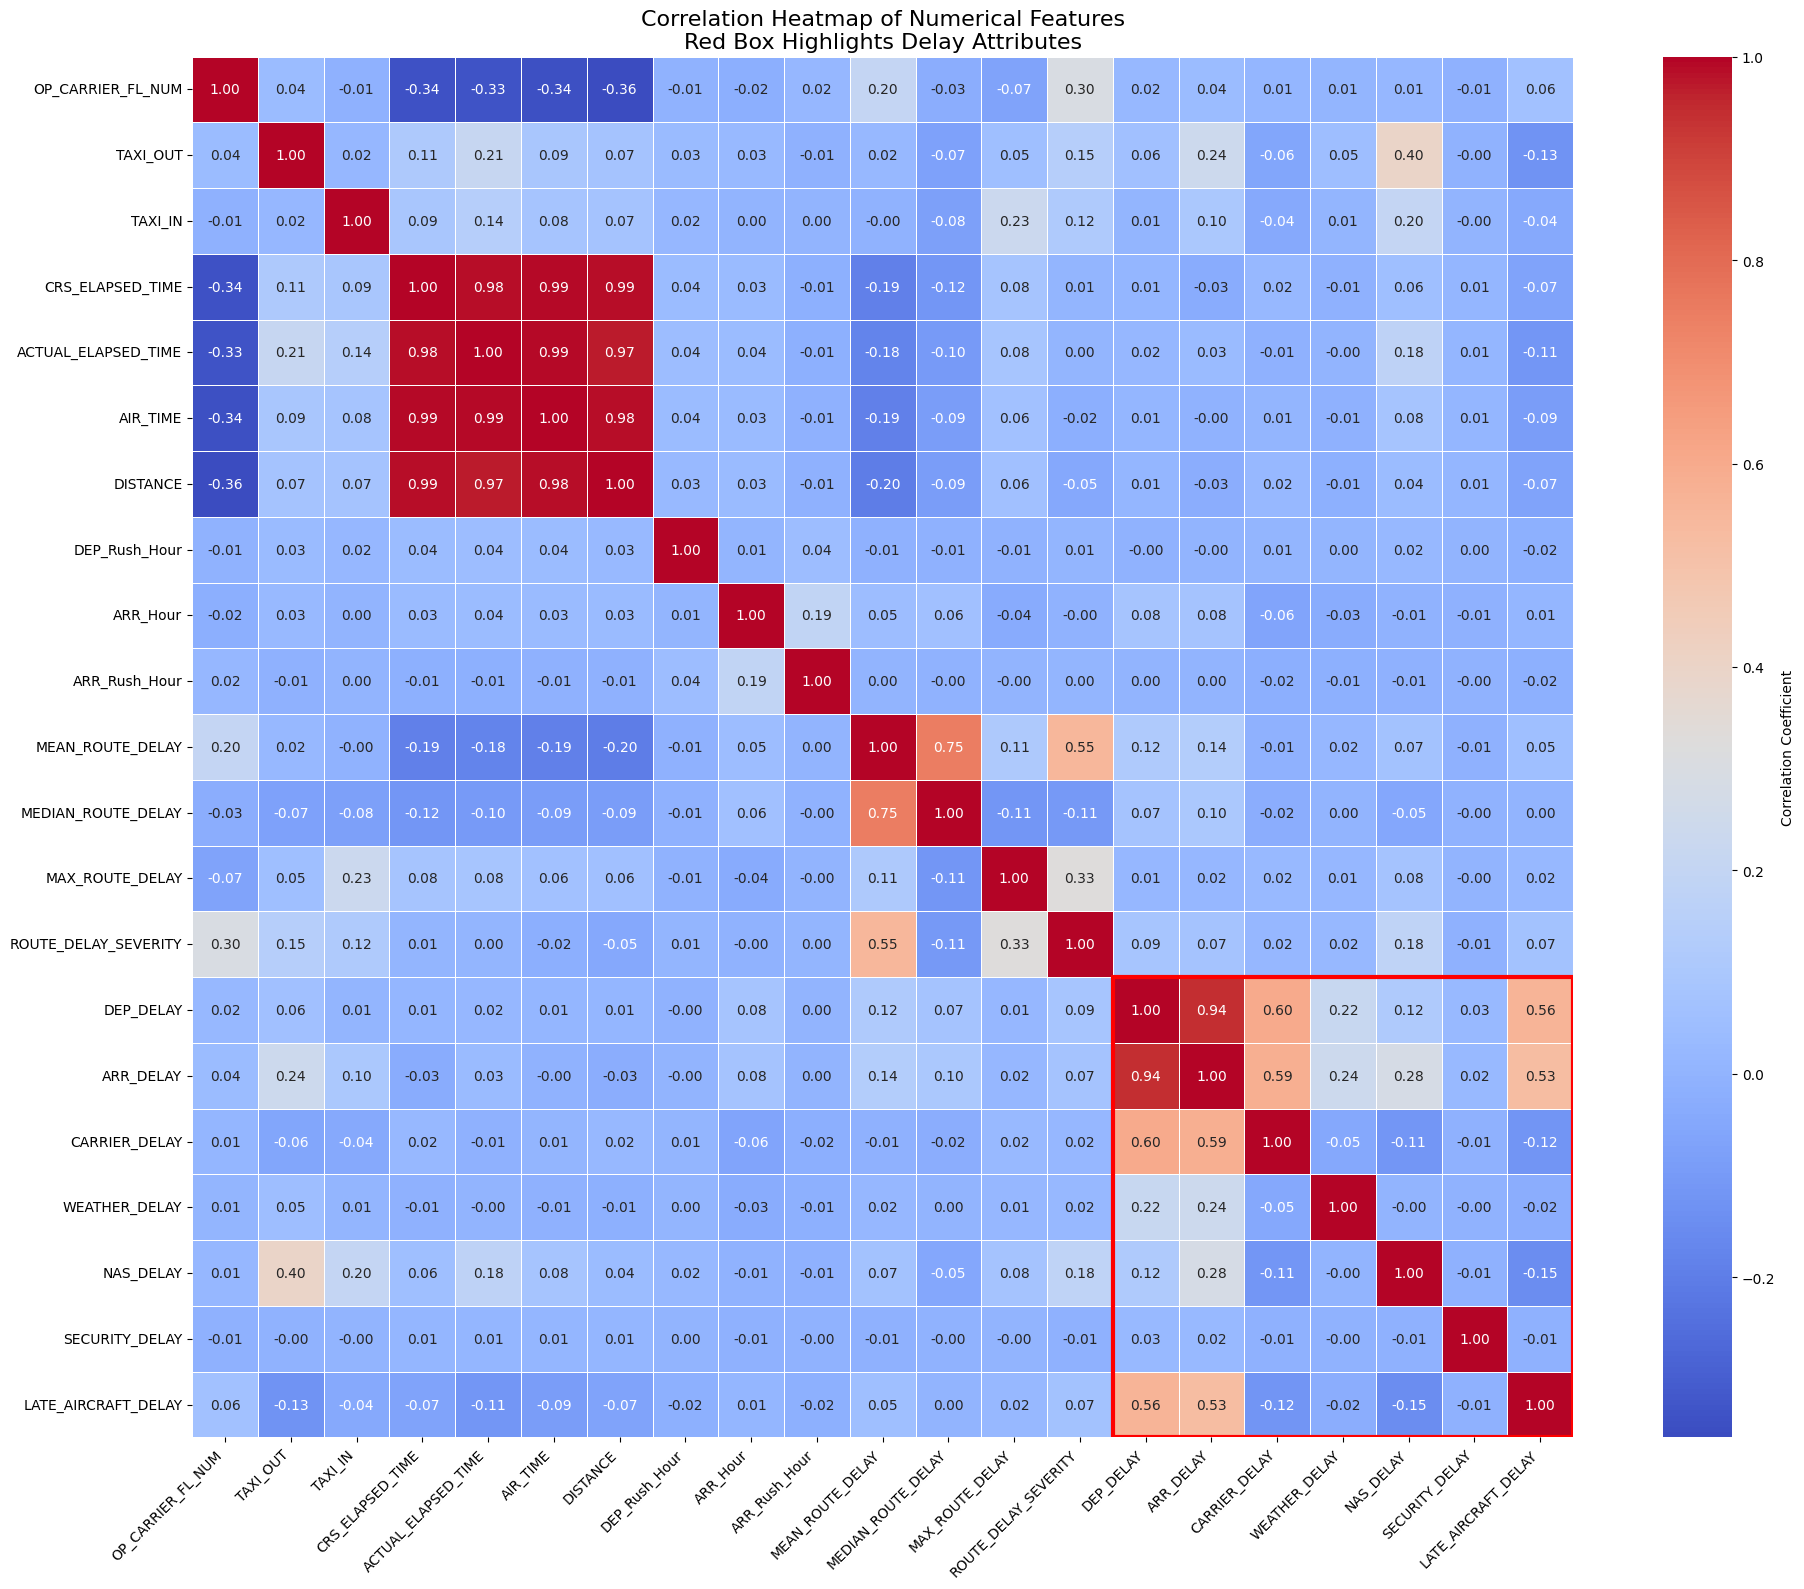


Detailed Delay Attributes Correlation:
                     DEP_DELAY  ARR_DELAY  CARRIER_DELAY  WEATHER_DELAY  \
DEP_DELAY             1.000000   0.943565       0.599600       0.216644   
ARR_DELAY             0.943565   1.000000       0.586183       0.237862   
CARRIER_DELAY         0.599600   0.586183       1.000000      -0.045391   
WEATHER_DELAY         0.216644   0.237862      -0.045391       1.000000   
NAS_DELAY             0.118713   0.280010      -0.114209      -0.000751   
SECURITY_DELAY        0.025990   0.024718      -0.010288      -0.004008   
LATE_AIRCRAFT_DELAY   0.564872   0.528156      -0.121655      -0.023464   

                     NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  
DEP_DELAY             0.118713        0.025990             0.564872  
ARR_DELAY             0.280010        0.024718             0.528156  
CARRIER_DELAY        -0.114209       -0.010288            -0.121655  
WEATHER_DELAY        -0.000751       -0.004008            -0.023464  
NAS_DELAY

In [32]:
# Define delay-related columns
delay_columns = ['DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 
                 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 
                 'LATE_AIRCRAFT_DELAY']

# Select all numerical columns
numerical_cols = flights_with_delay_metrics.select_dtypes(include=['int64', 'float64']).columns

#numerical_cols = numerical_cols.drop('YEAR', errors='ignore')
# Separate non-delay columns
non_delay_columns = [col for col in numerical_cols if col not in delay_columns]

# Reorder columns to group delay attributes together
reordered_columns = non_delay_columns + delay_columns

# Compute correlation matrix with reordered columns
corr_matrix = flights_with_delay_metrics[reordered_columns].corr()

# Create the plot
plt.figure(figsize=(20, 16))

# Create the heatmap
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5,
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'})

# Find the start index of delay columns
delay_start_index = len(non_delay_columns)

# Draw a rectangle around delay columns
plt.gca().add_patch(plt.Rectangle(
    (delay_start_index, delay_start_index), 
    len(delay_columns), 
    len(delay_columns), 
    fill=False, 
    edgecolor='red', 
    lw=3
))

plt.title('Correlation Heatmap of Numerical Features\nRed Box Highlights Delay Attributes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


delay_corr = corr_matrix.loc[delay_columns, delay_columns]
# Print out detailed delay correlations
print("\nDetailed Delay Attributes Correlation:")
print(delay_corr)

# Identify strongest correlations among delay attributes
def find_top_correlations(corr_matrix, n=5):
    # Create a mask to avoid duplicates and self-correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Flatten the correlation matrix
    corr_flat = corr_matrix.where(~mask).stack().reset_index()
    corr_flat.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # Sort by absolute correlation value
    top_correlations = corr_flat.reindex(
        corr_flat['Correlation'].abs().sort_values(ascending=False).index
    )
    
    return top_correlations.head(n)

print("\nTop 5 Correlations among Delay Attributes:")
print(find_top_correlations(delay_corr))

We can see from the constructed heat map that the newly constructed features (Mean delay, max route delay, median delay, route delay severity) have minimal correlation with the delay features. We will delve deeper into the results of the heatmap later, in the EDA notebook.

## Summary statistics

It is also important to make sure there are no illogical values within this dataset.

In [33]:
# Selecting only relevant numerical features for summary statistics
numerical_features = ['DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

# Generating descriptive statistics for numerical features
numerical_stats = df_cleaned[numerical_features].describe()

# Displaying the statistics
numerical_stats


,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,6259310.0,6259310.0,6259310.0,6259310.0,6259310.0,6259310.0,6259310.0,6259310.0,1269277.0,1269277.0,1269277.0,1269277.0,1269277.0
mean,9.684819,15.592381,6.772477,6.010872,132.994205,129.320258,106.9554,764.57842,16.652706,2.343187,13.729758,0.081661,23.868734
std,35.567039,9.033458,4.710094,38.052002,72.169934,71.66801,69.769858,585.970127,43.581631,17.025016,27.65401,2.627572,41.037532
min,-171.0,1.0,1.0,-153.0,20.0,11.0,5.0,31.0,0.0,0.0,0.0,0.0,0.0
25%,-5.0,10.0,4.0,-12.0,81.0,78.0,57.0,341.0,0.0,0.0,0.0,0.0,0.0
50%,-1.0,13.0,6.0,-3.0,114.0,110.0,87.0,596.0,1.0,0.0,3.0,0.0,7.0
75%,9.0,18.0,8.0,10.0,163.0,159.0,136.0,991.0,16.0,0.0,18.0,0.0,31.0
max,1975.0,237.0,346.0,1983.0,700.0,738.0,695.0,4983.0,1975.0,1591.0,1287.0,573.0,1182.0


It seems like all relevant numerical features have logical values. There are no negative values for 'AIR_TIME' and 'ACTUAL_ELAPSED_TIME' anymore.
A look at the statistics of the cancelled flights: 

In [34]:
df_cancel[numerical_features].describe()

,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,18491.0,15269.0,11897.0,0.0,110172.0,0.0,0.0,110172.0,0.0,0.0,0.0,0.0,0.0
mean,30.38489,17.761085,8.867446,<NA>,117.743456,<NA>,<NA>,620.012608,<NA>,<NA>,<NA>,<NA>,<NA>
std,69.650114,12.264476,9.133683,<NA>,61.819747,<NA>,<NA>,494.735281,<NA>,<NA>,<NA>,<NA>,<NA>
min,-33.0,1.0,1.0,<NA>,5.0,<NA>,<NA>,17.0,<NA>,<NA>,<NA>,<NA>,<NA>
25%,-3.0,11.0,5.0,<NA>,75.0,<NA>,<NA>,280.0,<NA>,<NA>,<NA>,<NA>,<NA>
50%,3.0,15.0,7.0,<NA>,103.0,<NA>,<NA>,489.0,<NA>,<NA>,<NA>,<NA>,<NA>
75%,35.0,20.0,10.0,<NA>,142.0,<NA>,<NA>,792.0,<NA>,<NA>,<NA>,<NA>,<NA>
max,1743.0,154.0,227.0,<NA>,660.0,<NA>,<NA>,4963.0,<NA>,<NA>,<NA>,<NA>,<NA>


As we can see, most of the same features are simply not available, which is to be expected.

## Wrapping up

**The data formatting is done, we will save the two dataframes into files and utilize them in the next notebooks on EDA and ML.**

In [35]:
df_cleaned.to_csv('df_cleaned.csv', index=False)
df_cancel.to_csv('df_cancel.csv', index=False)